# Tree based (Decision tree, random forest, XGBoost)

1. Agenda
 - Bootstrapping
 - Decision Tree
 - Random forest
 - XGBoost

In [1]:

pip install wooldridge shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 14.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wooldridge as wd
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Bootstrap

Se utiliza para aproximar la distribución en el muestreo de un estadístico.

### Algoritmo

- Con una muestra dada de datos

$$x={x_i;1,...,n}$$

- Se seleccionan $B$ muestras bootstrap independientes cada una con $n$ elementos obtenidos de la muestra original.

- Para cada muestra bootstrap se calcula el estadístico de interés $\theta(b)=t(x_B)$

- La muestra de estadísticos resultante será la distribución de probabilidades del estadístico.

- Se puede calcular el error estándar como:

$$se_B=\bigg\{\frac{1}{B-1}\sum_{b=1}^B[\theta(b)-\bar{\theta}]^2 \bigg\}^{1/2}$$



In [3]:
from scipy import stats
from sklearn.utils import resample

In [4]:
x = np.random.randn(100)

In [5]:
boot = resample(x, replace=True, n_samples=len(x))

In [6]:
sample = [resample(x, replace=True, n_samples=len(x)) for _ in range(500)]

In [7]:
estad = [np.mean(m) for m in sample]



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: ylabel='Density'>

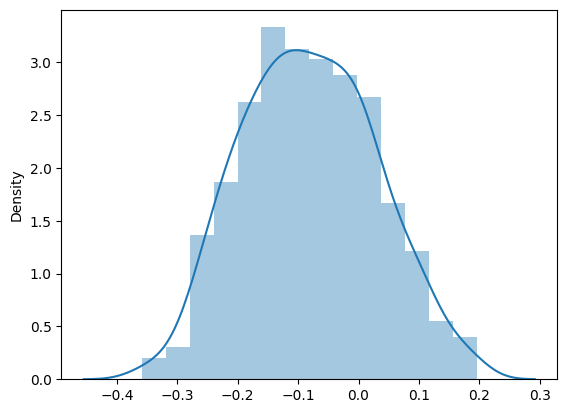

In [8]:
sns.distplot(estad)

## Métricas de clasificación

### Métricas

1. Matriz de confusión


||Pr|Nr|
|---|---|---
|Pe|TP|FP|
|Ne|FN|TN|

Error tipo I: falso positivo

Error tipo II: falso negativo

2. Accuracy score

$$\frac{TP+TN}{TP+TN+FP+FN}$$

3. Recall (sensitivity) score

$$\frac{TP}{TP+FN}$$

4. Precision score

$$\frac{TP}{TP+FP}$$

5. F1 score

$$\frac{2 \text{ x precision x recall}}{\text{precision+recall}}$$

6. Specificity

$$\frac{TN}{TN+FP}$$

7. ROC curve: Sensitivity vs. 1 - specificity

8. Precision-recall curve

## Decision Tree

Los métodos basados en árboles que se verán a continuación pueden ser utilizados tanto para regresión como para clasificación.

El proceso para la construcción de un árbol de decisión es simple:

1. Se divide el espacio de variables independientes en $J$ regiones diferentes sin traslaparse:

$$R_1,R_2,...,R_J$$

2. Para cada observación que cae en la región $R_j$ se hace la misma predicción, simplemente la media de las variables de respuesta para el número de observaciones en $R_j$.

¿Cómo se construyen las regiones $R_1,...,R_J$? El objetivo es encontrar cajas $R_1,...,R_j$ que minimicen RSS

$$\sum_{j=1}^J\sum_{i\in R_j}(y_i-\hat{y}_{R_j})^2$$

Donde $\hat{y}_{R_j}$ es la media de la variable de respuesta para las observaciones de entrenamiento dentro de la $j$-ésima caja.

Aunque es la intención, es computacionalmente costoso llevarlo a cabo de esta forma.

Para contrarrestar esto se puede hacer splitting binario recursivo. Se selecciona una variable $X_j$ y el punto de corte $s$ de tal forma que se devida el espacio de la variable en las regiones

$$\{X|X_j<s\} \text{ y }\{X|X_j\geq s\}$$

que lleven a la mayor reducción posible en RSS.

Formalmente, para cualquier $j$ y $s$ se define un par de planos

$$R_1(j,s)=\{X|X_j <s\} \text{ y }R_2(j,s)=\{X|X_j\geq s\}$$

y se busca el valor de $j$ y $s$ que minimice la ecuación

$$\sum_{}(y_i-\hat{y}_{R_1})^2+\sum_{}(y_i-\hat{y}_{R_2})^2$$

El proceso continúa hasta que se alcance un criterio determinado.

Es posible que este proceso pueda producir buenas predicciones en el conjunto de entrenamienot, pero puede llevar a un mal desempeño en el conjunto de testeo. Hay una estrategia y consiste en hacer crecer un árbol grande $T_0$ y podarlo para obtener un subárbol. ¿Cuál es la mejor forma de podar? Tomar cada subárbol es costoso computacionalmente, así que se toma una secuencia de árobles indexados por un parámetro no negativo $\alpha$. Para cada valor de $\alpha$ corresponde un subárbol $T$ $\subset$ $T_0$ tal que

$$\sum_{m=1}^{|T|}\sum_{i:x_i \in R_m}(y_i-\hat{y}_{R_m})^2+\alpha|T|$$

sea tan pequeño como sea posible.

El algoritmo para regresión es el siguiente:

1. Emplear splitting binario recursivo para hacer crecer un árbol, deteniéndose únicamente cuando cada nodo temrinal tenga menos de un número específico de observaciones.

2. Aplicar cost complexity pruning al árbol para obtener una secuencia de mejores subárboles, como una función de $\alpha$.

3. Utilizar K-fold cross-validation para escoger $\alpha$. Esto es dividir el conjunto de entrenamiento en $K$ folds para encontrar el mejor $\alpha$.

4. Devolver el árbol que corresponda con el mejor valor de $\alpha$.

Básicamente, hacer crecer un árbol y encontrar el que mejor parámetro $\alpha$ tenga.

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

In [10]:
!pip install wooldridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import wooldridge as wd

In [11]:
df = wd.data('mroz')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   inlf      753 non-null    int64  
 1   hours     753 non-null    int64  
 2   kidslt6   753 non-null    int64  
 3   kidsge6   753 non-null    int64  
 4   age       753 non-null    int64  
 5   educ      753 non-null    int64  
 6   wage      428 non-null    float64
 7   repwage   753 non-null    float64
 8   hushrs    753 non-null    int64  
 9   husage    753 non-null    int64  
 10  huseduc   753 non-null    int64  
 11  huswage   753 non-null    float64
 12  faminc    753 non-null    float64
 13  mtr       753 non-null    float64
 14  motheduc  753 non-null    int64  
 15  fatheduc  753 non-null    int64  
 16  unem      753 non-null    float64
 17  city      753 non-null    int64  
 18  exper     753 non-null    int64  
 19  nwifeinc  753 non-null    float64
 20  lwage     428 non-null    float6

In [ ]:
y = df['inlf']
X = df[['kidslt6','age']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def metricas(y_test, y_pred):
  print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
  print(f'f1_score: {f1_score(y_test, y_pred)}')

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
metricas(y_test, y_pred)

Accuracy: 0.5629139072847682
f1_score: 0.6597938144329897


In [ ]:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
              'min_samples_split': [4, 5, 6, 7, 8]}

tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)

In [ ]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [4, 5, 6, 7, 8]})

In [ ]:
y_pred = tree_grid.predict(X_test)

In [ ]:
metricas(y_pred, y_test)

Accuracy: 0.5761589403973509
f1_score: 0.6190476190476191


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
metricas(y_test, y_pred)

Accuracy: 0.5761589403973509
f1_score: 0.6862745098039216


In [ ]:
param_grid = {'n_estimators':[50, 100, 150, 200],
              'max_depth': [4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [5, 10, 15, 20],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 15, 20]}

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3)
rf_grid.fit(X_train, y_train)
y_pred = rf_grid.predict(X_test)
metricas(y_test, y_pred)


Accuracy: 0.5960264900662252
f1_score: 0.6702702702702703


In [ ]:
import seaborn as sns

<Axes: >

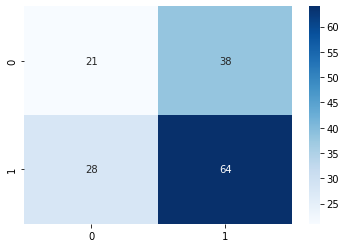

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

In [ ]:
gpa = wd.data('gpa1')

In [ ]:
wd.data('gpa1', description=True)

name of dataset: gpa1
no of variables: 29
no of observations: 141

+----------+--------------------------------+
| variable | label                          |
+----------+--------------------------------+
| age      | in years                       |
| soph     | =1 if sophomore                |
| junior   | =1 if junior                   |
| senior   | =1 if senior                   |
| senior5  | =1 if fifth year senior        |
| male     | =1 if male                     |
| campus   | =1 if live on campus           |
| business | =1 if business major           |
| engineer | =1 if engineering major        |
| colGPA   | MSU GPA                        |
| hsGPA    | high school GPA                |
| ACT      | 'achievement' score            |
| job19    | =1 if job <= 19 hours          |
| job20    | =1 if job >= 20 hours          |
| drive    | =1 if drive to campus          |
| bike     | =1 if bicycle to campus        |
| walk     | =1 if walk to campus           |
| voluntr  | 

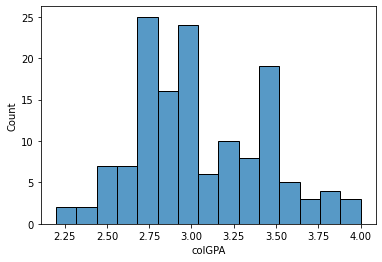

In [ ]:
sns.histplot(data=gpa, x='colGPA', bins=15)

In [ ]:
X = gpa.filter(['PC','hsGPA','ACT'])
y = gpa.pop('colGPA')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [ ]:
y_pred = reg_tree.predict(X_test)
y_fit_train = reg_tree.predict(X_train)

In [ ]:
def metricas(y_true, y_pred):
  print(f'MSE: {mean_squared_error(y_true, y_pred)}')
  print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE: {np.sqrt(mean_squared_error(y_true,y_pred))}')

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 0.08627729899187123
MAE: 0.23557414744824343
RMSE: 0.29372997632497644
------------------------------
Métricas del testeo
------------------------------
MSE: 0.1054165372866283
MAE: 0.2359905482789325
RMSE: 0.32467912973677304


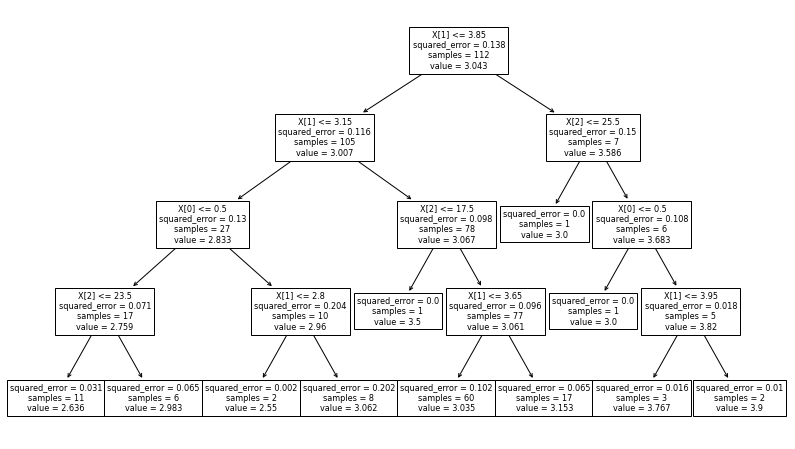

In [ ]:
from sklearn import tree

fig, ax = plt.subplots(1,1, figsize=(14,8))
tree.plot_tree(reg_tree, ax=ax)
plt.show()

In [ ]:
wage1 = wd.data('wage1')

In [ ]:
X = wage1.filter(['female','educ','exper','tenure'])
y = wage1.pop('wage')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
reg_tree2 = DecisionTreeRegressor(max_depth=3)
reg_tree2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [ ]:
y_pred = reg_tree2.predict(X_test)
y_pred_train = reg_tree2.predict(X_train)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_pred_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 8.189002058642126
MAE: 1.9846693877965496
RMSE: 2.8616432444737283
------------------------------
Métricas del testeo
------------------------------
MSE: 9.434193648199999
MAE: 2.1117408786822827
RMSE: 3.071513250533033


[Text(0.5, 0.875, 'X[1] <= 15.5\nsquared_error = 13.533\nsamples = 420\nvalue = 5.859'),
 Text(0.25, 0.625, 'X[3] <= 2.5\nsquared_error = 8.628\nsamples = 344\nvalue = 5.195'),
 Text(0.125, 0.375, 'X[0] <= 0.5\nsquared_error = 3.86\nsamples = 177\nvalue = 4.171'),
 Text(0.0625, 0.125, 'squared_error = 5.92\nsamples = 76\nvalue = 4.884'),
 Text(0.1875, 0.125, 'squared_error = 1.64\nsamples = 101\nvalue = 3.635'),
 Text(0.375, 0.375, 'X[0] <= 0.5\nsquared_error = 11.393\nsamples = 167\nvalue = 6.281'),
 Text(0.3125, 0.125, 'squared_error = 14.679\nsamples = 93\nvalue = 7.175'),
 Text(0.4375, 0.125, 'squared_error = 4.992\nsamples = 74\nvalue = 5.156'),
 Text(0.75, 0.625, 'X[3] <= 4.5\nsquared_error = 24.708\nsamples = 76\nvalue = 8.864'),
 Text(0.625, 0.375, 'X[2] <= 9.5\nsquared_error = 10.207\nsamples = 56\nvalue = 7.287'),
 Text(0.5625, 0.125, 'squared_error = 5.181\nsamples = 39\nvalue = 6.452'),
 Text(0.6875, 0.125, 'squared_error = 16.464\nsamples = 17\nvalue = 9.204'),
 Text(0.875

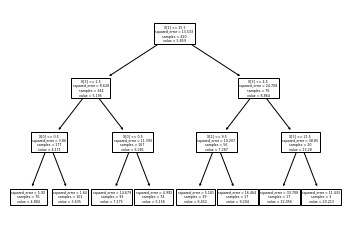

In [ ]:
tree.plot_tree(reg_tree2)

In [ ]:
tree

<module 'sklearn.tree' from '/usr/local/lib/python3.7/dist-packages/sklearn/tree/__init__.py'>

In [ ]:
explainer = shap.Explainer(reg_tree2.predict, X_test)
shap_values = explainer(X_test)

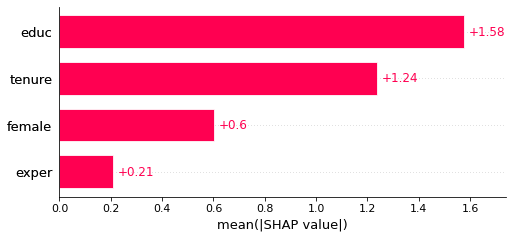

In [ ]:
shap.plots.bar(shap_values)

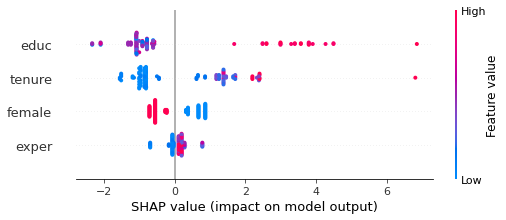

In [ ]:
shap.plots.beeswarm(shap_values, )

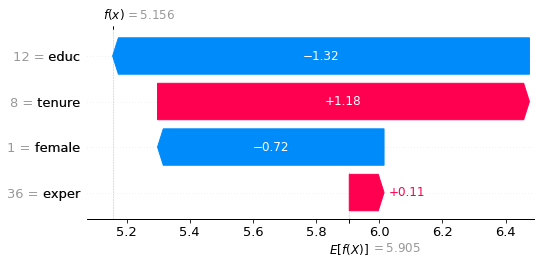

In [ ]:
shap.plots.waterfall(shap_values[0])

### Árboles de clasificación

El proceso es similar al de un árbol de regresión. Para el problema de regresión, la respuesta predicha para una observación es dada por la media de la respuesta de las observaciones de entrenamiento que pertenecen al mismo nodo. Para los árboles de decisión, se predice que cada observación pertenece a la clase más común en las observaciones de entrenamiento que pertenecen al nodo en cuestión.

La diferencia radica en que en este caso no se puede utilizar RSS como criterio para hacer los splits binarios. En su lugar pueden ser utilizados el índice Gini o la entropía:

$$G=\sum_{k=1}^K\hat{p}_{mk}(1-\hat{p}_{mk})$$

$$D=-\sum_{k=1}^K\hat{p}_{mk}\log \hat{p}_{mk}$$

Cuando se está construyendo un árbol de clasificación, cualquier de los dos es utilizado para evaluar la calidad de un split específico. Pueden ser utilizados para podar el árbol, pero si el ojetivo es la precisión de la predicción la tasa de error de clasificación puede ser mejor

$$E=1-\max_k(\hat{p}_{mk})$$

In [ ]:
mroz = wd.data('mroz')

In [ ]:
mroz = wd.data('mroz', description=True)

name of dataset: mroz
no of variables: 22
no of observations: 753

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| inlf     | =1 if in lab frce, 1975         |
| hours    | hours worked, 1975              |
| kidslt6  | # kids < 6 years                |
| kidsge6  | # kids 6-18                     |
| age      | woman's age in yrs              |
| educ     | years of schooling              |
| wage     | est. wage from earn, hrs        |
| repwage  | rep. wage at interview in 1976  |
| hushrs   | hours worked by husband, 1975   |
| husage   | husband's age                   |
| huseduc  | husband's years of schooling    |
| huswage  | husband's hourly wage, 1975     |
| faminc   | family income, 1975             |
| mtr      | fed. marg. tax rte facing woman |
| motheduc | mother's years of schooling     |
| fatheduc | father's years of schooling     |
| unem     | unem. rate in county of res

In [ ]:
y = mroz.pop('inlf')
X = mroz.filter(['kidslt6','age','educ','exper'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
clsr = DecisionTreeClassifier(max_depth=4)
clsr.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
y_pred = clsr.predict(X_test)
y_fit_train = clsr.predict(X_train)

In [ ]:
def metricas_clas(y_true, y_pred):
  print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
  print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
  print(f"Recall: {recall_score(y_true, y_pred,average='weighted')}")

In [ ]:
print('---'*10)
print('Métricas en entrenamiento')
print('---'*10)
metricas_clas(y_train, y_fit_train)
print('---'*10)
print('Métricas en testeo')
print('---'*10)
metricas_clas(y_test, y_pred)

------------------------------
Métricas en entrenamiento
------------------------------
Accuracy: 0.7408637873754153
Precision: 0.7420095758469217
Recall: 0.7408637873754153
------------------------------
Métricas en testeo
------------------------------
Accuracy: 0.6887417218543046
Precision: 0.6906097912116466
Recall: 0.6887417218543046


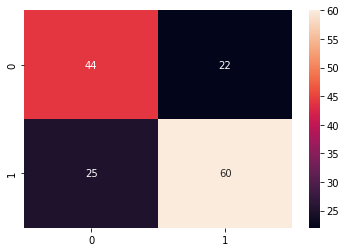

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

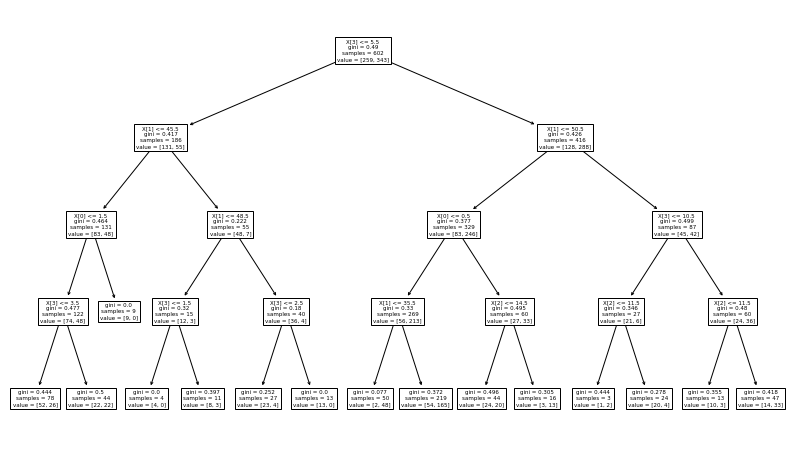

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
tree.plot_tree(clsr, ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.65        66
           1       0.73      0.71      0.72        85

    accuracy                           0.69       151
   macro avg       0.68      0.69      0.69       151
weighted avg       0.69      0.69      0.69       151



In [ ]:
explainer = shap.Explainer(clsr.predict, X_test)
shap_values = explainer(X_test)

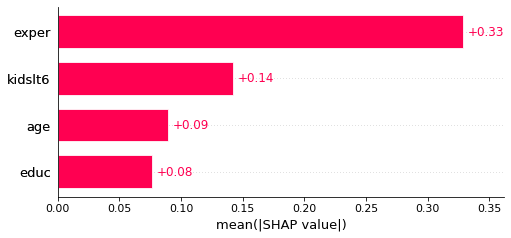

In [ ]:
shap.plots.bar(shap_values)

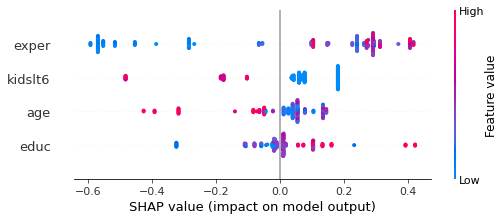

In [ ]:
shap.plots.beeswarm(shap_values)

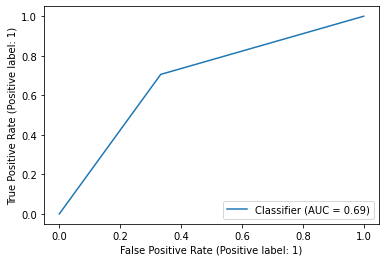

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_pred)

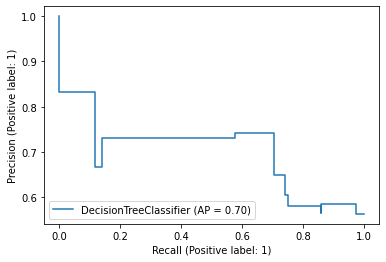

In [ ]:
PrecisionRecallDisplay.from_estimator(clsr, X_test, y_test)

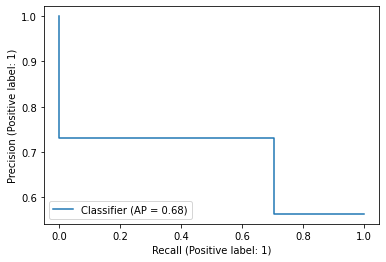

In [ ]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

### Ventajas y desventajas de los árboles de decisión

#### Ventajas

- Son fáciles de explicar a las personas. Son incluso más fáciles de explicar que la regresión lineal.
- Se cree que se parece más a la forma en que una persona toma decisiones que otros modelos.
- Los árboles pueden trabajar con variables cualitativas sin la necesidad de crear variables dummy.
#### Desventajas

- No tienen usualmente la misma precisión de otros modelos de regresión y clasificación.

- Los árboles pueden ser poco robustos. Un pequeño cambio en los datos puede provocar un gran cambio en el árbol estimado final.

Todo esto se puede mejorar a través de random forests y metodologías de boosting.

## Random Forest

Una forma de reducir la varianza de un estimador es promediar juntos varios estimadores. Por ejemplo, se pueden entrenar $M$ árboles diferentes en diferentes subconjuntos de los datos, seleccionados aleatoriamente con remplazo, y así computar el ensable

$$f(\textbf{x})=\sum_{m=1}^M\frac{1}{M}f_m(\textbf{x})$$

donde $f_m$ es el árbol $m$-ésimo. Esto es conocido como bagging, que proviene de "bootstrap aggregating".

No obstante, las consecuencias de estos puede ser que se tengan variables predictoras altamente correlacionadas, lo cuál limita el monto de reducción de varianza posible.

La técnica de "Random forest" intenta evitar esta correlación creando árboles basados en selección aleatoria subconjunto de variables predictores, así como un subconjunto del total de los datos.

Como en el bagging, se construyen un número de árboles de decisión en muestras boostrap de entrenamiento. Pero cuando estos árboles de decisión se van construir, cada vez que se considera un split en el árbol, se toma una muestra aleatoria de $m$ variables predictoras del conjunto total de $p$ variables existentes.

La técnica de RF puede que no tome en cuenta la mayoría de las variables. ¿Por qué?

Suponga que hay una predictora fuerte, junto con predictoras moderadas. En el bagging, la mayoría o todos los árboles utilizarán la predictora fuerte, como consecuencia los árboles serán muy similares entre sí. RF fuerza que cada split considere solo un subconjunto de las predictoras.

Si $m=p$ se tiene bagging, usualmente para RF se piensa en $m=\sqrt{p}$

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_regression, make_classification

In [ ]:
X, y = make_classification(n_samples=1000,n_features=4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
rf_cls = RandomForestClassifier(n_estimators=10)
rf_cls.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
y_fit_train = rf_cls.predict(X_train)
y_pred = rf_cls.predict(X_test)

In [ ]:
print('---'*10)
print('Métricas en entrenamiento')
print('---'*10)
metricas_clas(y_train, y_fit_train)
print('---'*10)
print('Métricas en testeo')
print('---'*10)
metricas_clas(y_test, y_pred)

------------------------------
Métricas en entrenamiento
------------------------------
Accuracy: 0.97875
Precision: 0.9789913227016885
Recall: 0.97875
------------------------------
Métricas en testeo
------------------------------
Accuracy: 0.845
Precision: 0.8470192307692307
Recall: 0.845


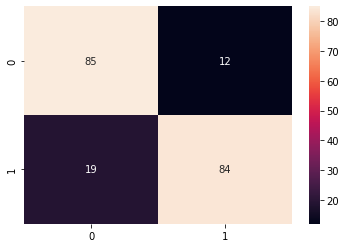

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        97
           1       0.88      0.82      0.84       103

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.84       200



In [ ]:
explainer = shap.Explainer(rf_cls.predict, X_test)
shap_values = explainer(X_test)

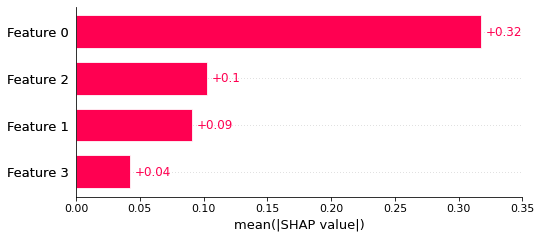

In [ ]:
shap.plots.bar(shap_values)

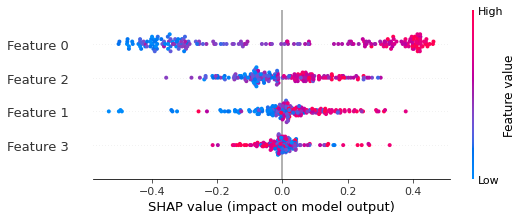

In [ ]:
shap.plots.beeswarm(shap_values)

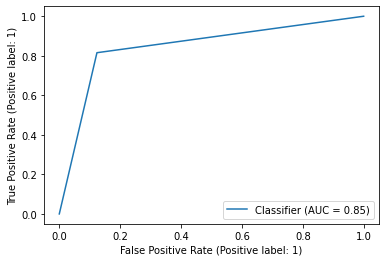

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

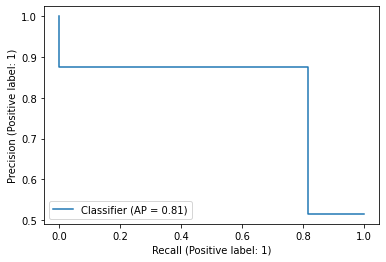

In [ ]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

In [ ]:
X, y = make_regression(n_samples=1000, n_features=4, noise=0.2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
rf_reg = RandomForestRegressor(max_depth=4, n_estimators=20)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=20)

In [ ]:
y_fit_train = rf_reg.predict(X_train)
y_pred = rf_reg.predict(X_test)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 3346.449023051482
MAE: 43.38697536830657
RMSE: 57.84850061195607
------------------------------
Métricas del testeo
------------------------------
MSE: 4391.157771365153
MAE: 50.69414743592968
RMSE: 66.2658114819788


In [ ]:
X_train

array([[ 0.51481064,  0.0518232 , -0.60234429, -0.49101798],
       [ 1.9902416 ,  0.52653726, -0.82243214, -0.20797399],
       [-0.57445411,  0.19003424, -1.34644334, -0.28004291],
       ...,
       [ 1.34261918,  1.0341338 ,  0.22506827, -0.33887945],
       [ 0.97827634,  0.69483768,  0.90345869,  0.34743261],
       [-0.47756891,  0.42927652,  1.15545582, -0.11841717]])

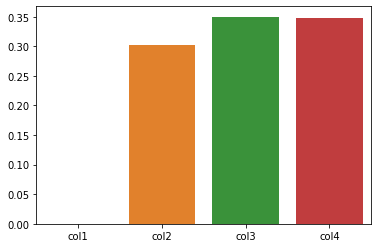

In [ ]:
sns.barplot(x=[f'col{i}' for i in range(1, 5)], y=rf_reg.feature_importances_)

In [ ]:
explainer = shap.Explainer(rf_reg.predict, X_test)
shap_values = explainer(X_test)

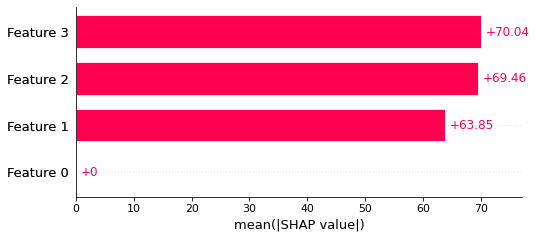

In [ ]:
shap.plots.bar(shap_values)

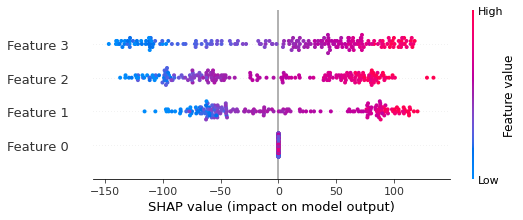

In [ ]:
shap.plots.beeswarm(shap_values)

## Boosting

Existe otro método para mejorar la predicción de un árbol de decisión. Mientras el bagging consiste en crear multiples copias de los datos de entrenamiento utilizando bootstrap, ajustando un árbol de decisión por separado para cada uno, y después los combina para crear un solo modelo predictivo, el boosting hace algo similar, excepto que los árboles crecen secuencialmente: cada árbol crece utilizando información de los árboles precedentes.

El boosting no utiliza boostrap, en lugar de eso cada árbol es ajustado en una versión modificada de los datos de entrenamiento.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression

In [ ]:
X, y = make_regression(n_samples=1000, n_features=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train,y_train)

y_train2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y_train2)

y_train3 = y_train2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y_train3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Lo visto anteriormente se puede utilizar el módulo `GradientBoosting`  de sklearn. Puede utilizarse tanto para regresión como para clasificación.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=4, n_estimators=3, learning_rate=1)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_fit_train = gbrt.predict(X_train)
y_pred = gbrt.predict(X_test)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 1024.9144025943888
MAE: 24.896691201366142
RMSE: 32.014284352369785
------------------------------
Métricas del testeo
------------------------------
MSE: 2256.5532104179088
MAE: 36.77347554760655
RMSE: 47.503191581386496


## XGBoost


In [ ]:
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=3)

In [ ]:
wage1 = wd.data('wage1')
X = wage1.filter(['female','educ','exper','tenure'])
y = wage1.pop('wage')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=3,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_fit_train = xg_reg.predict(X_train)
y_pred = xg_reg.predict(X_test)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 26.662555126801383
MAE: 3.9500313145773753
RMSE: 5.163579681461436
------------------------------
Métricas del testeo
------------------------------
MSE: 27.490410669700978
MAE: 4.03102677385762
RMSE: 5.243129854361894
